# Getting similar images with a supervised approach

In this we will see a method where you can use supervised images set to predict similar images

This approach is a alterenative to what we use as a image similarity model using a pretrained model and remove final dense layer. This approach gives you flexibility to train you models on your own dataset to learn features better.

This task is a emulsion of 2 tasks 
1. We will use a supervised data to teach our model how to transform a given train image to a target image ex. passing a photograph with background as input and expecting image with black background as output
2. Once our this model is ready we will use Encoder part of this to extract usable information
3. We will use this encoder to calculate nearest objects to a given object.

Using Auto Encoders for Image Similarity was inspired by https://medium.com/pytorch/image-similarity-search-in-pytorch-1a744cf3469

## Loading libraries 

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
from PIL import Image
from torchinfo import summary
import numpy as np
import torchvision.transforms as T
from sklearn.neighbors import NearestNeighbors
device= "cuda" if torch.cuda.is_available() else 'cpu'
print("Torch Version => {} \nIs Torch using CUDA => {} \nTotal GPU available => {} \nCurrently using => {}".format(torch.__version__,torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(torch.cuda.current_device())))

Torch Version => 1.13.1 
Is Torch using CUDA => True 
Total GPU available => 1 
Currently using => NVIDIA A100-SXM4-40GB


In [2]:
!nvidia-smi ##Get GPU status

Mon Jan 23 00:33:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0   411W / 400W |  38637MiB / 40960MiB |     94%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

## Config Paths

Here we will have 2 types of dataset input and output <br>
In Document from here input is referred as train and output is referred as target<br>
Note: Name of input image and corresponding output image should be samebut needs to be kept in diff folder

In [3]:
Train_path = "data/train/"
Target_path = "data/target/"

IMG_HEIGHT = 512  # The images are already resized here
IMG_WIDTH = 512  # The images are already resized here

SEED = 42
TRAIN_RATIO = 0.75
VAL_RATIO = 1 - TRAIN_RATIO
SHUFFLE_BUFFER_SIZE = 100
EARLY_STOP = 3
LOAD_MODEL=False

LEARNING_RATE = 1e-3
loss= nn.MSELoss()
EPOCHS = 150
TRAIN_BATCH_SIZE = 256  # Let's see, I don't have GPU, Google Colab is best hope
TEST_BATCH_SIZE = 256  # Let's see, I don't have GPU, Google Colab is best hope

transforms= T.Compose([T.ToTensor()])

MODEL_SAVE_PATH = "baseline_autoencoder.pt"
EMBEDDING_SAVE_PATH = "embeddings.npy"

## Buildng DataLoader

In [4]:
class FolderDataset(torch.utils.data.Dataset):
    def __init__(self, train_dir, target_dir, transform=T.Compose([T.ToTensor()])):
        super().__init__()
        self.train_dir = train_dir
        self.target_dir = target_dir
        self.train_transform = transform
        self.target_transform = T.Compose([T.ToTensor()])
        self.train_all_img = os.listdir(train_dir)
        self.target_all_img = os.listdir(target_dir)

    def __len__(self):
        return len(self.train_all_img)
    
    def load_image(self, index:int) ->Image.Image:
        return Image.open(self.train_all_img[index])
    
    def __getitem__(self, idx:int):
        train_loc = os.path.join(self.train_dir, self.train_all_img[idx])
        train_images = Image.open(train_loc).convert("RGB").resize((IMG_HEIGHT, IMG_WIDTH))
        if self.train_transform:
            train_tensor = self.train_transform(train_images)
        else:
            raise Exception("Correct transform not given")
            
        target_loc=self.target_dir+train_loc.split("/")[-1]
        if train_loc.split("/")[-1] in self.target_all_img:
            target_images = Image.open(target_loc).convert("RGB").resize((IMG_HEIGHT, IMG_WIDTH))
            target_tensor = self.target_transform(target_images)
            return train_tensor, target_tensor
        else:
            print(train_loc, setarget_loc)
            return train_tensor, train_tensor

In [5]:
full_dataset = FolderDataset(Train_path,Target_path, transforms)
train_size = int(TRAIN_RATIO * len(full_dataset))

## Split train val
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, len(full_dataset) - train_size])

## Dataloader
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, drop_last=False)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, drop_last=False)
print(f"Data Loaded Successfully \t\t Full Dataset Size : {len(full_dataset)}\t\t Full Dataloader Size : {len(full_loader)}")

Data Loaded Successfully 		 Full Dataset Size : 4738		 Full Dataloader Size : 19


## Model

This is a 2 part autoencoder with encoder having far more neurons than decoder which will help model to learn most of the things at encoder end

In [6]:
torch.cuda.manual_seed_all(SEED)
torch.manual_seed(SEED)

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(8, 16, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(32, 64, (3, 3), padding=(1, 1)),
            nn.ReLU(),
            nn.Conv2d(64, 128, (3, 3), padding=(1, 1)),
            nn.ReLU())
            

    def forward(self, x):
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()    
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, (2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 16, (2, 2), stride=(2, 2)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2)),
            nn.ReLU())
    def forward(self, x):
        return self.decoder(x)
    
    
# initialize the NN
encoder = Encoder().to(device)
decoder = Decoder().to(device)

print("\t\t\t","\033[1m" + "Encoder" + "\033[0m")
print(summary(encoder))
print("\n\t\t\t","\033[1m" + "Decoder" + "\033[0m")
print(summary(decoder))



			 Encoder
Layer (type:depth-idx)                   Param #
Encoder                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       224
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       1,168
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       4,640
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
│    └─Conv2d: 2-10                      18,496
│    └─ReLU: 2-11                        --
│    └─Conv2d: 2-12                      73,856
│    └─ReLU: 2-13                        --
Total params: 98,384
Trainable params: 98,384
Non-trainable params: 0

			 Decoder
Layer (type:depth-idx)                   Param #
Decoder                                  --
├─Sequential: 1-1                        --
│    └─ConvTranspose2d: 2-1              32,

## Training

In [7]:
!nvidia-smi

Mon Jan 23 00:33:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0   402W / 400W |  38637MiB / 40960MiB |     92%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [8]:
def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        
        enc_out=encoder(train_img)
        dec_out=decoder(enc_out)

        loss = loss_fn(dec_out, target_img)
        loss.backward()

        optimizer.step()

    return loss.item()


def val_step(encoder, decoder, val_loader, loss_fn, device):

    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            train_img = train_img.to(device)
            target_img = target_img.to(device)
            
            enc_out=encoder(train_img)
            dec_out=decoder(enc_out)

            loss = loss_fn(dec_out, target_img)

    return loss.item()

In [9]:
def create_embedding(image_path, test_encod, test_decod):
    image_tensor = T.ToTensor()(Image.open(image_path).convert("RGB"))
    image_tensor = image_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        image_embedding = test_encod(image_tensor)
        return test_decod(image_embedding)
def test_plot(encoder, decoder):
    '''
    Build plot that you can use to visualize results while inferencing
    '''
    test_encod=encoder.to(device)
    test_decod=decoder.to(device)
    f, axarr = plt.subplots(3,2)
    f.suptitle("Input                       Prediction")
    for i, img in enumerate(os.listdir(Target_path)[:3]):
        axarr[i,0].imshow((np.asarray(Image.open(Target_path+img))))
        axarr[i,0].axis('off')
        axarr[i,0].set_aspect('equal')
        axarr[i,1].imshow((create_embedding(Target_path+img, test_encod, test_decod).cpu()[0].permute(1, 2, 0).detach().numpy()*255).astype(np.uint8))
        axarr[i,1].axis('off')
        axarr[i,1].set_aspect('equal')
    plt.subplots_adjust(wspace=-0.5, hspace=0.2)
    plt.show()
# test_plot(encoder, decoder)

------------ Training started ------------
      Available GPU : 38.547/39.424 GB


  0%|          | 0/150 [00:00<?, ?it/s]

 Epochs = 1 

   - Plotting Sample inference -


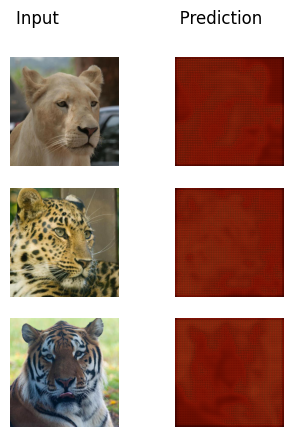

----------------------------------------------------------------------------------------------------
 Epochs = 2 
	 Training Loss : 0.1394131  Validation Loss : 0.1410445, Memory Left : 12.516/39.424 GB, C.P.

   - Plotting Sample inference -


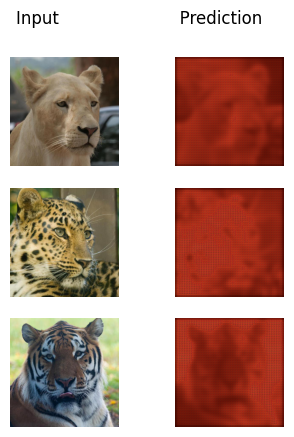

----------------------------------------------------------------------------------------------------
 Epochs = 3 
	 Training Loss : 0.119959  Validation Loss : 0.1215726, Memory Left : 12.516/39.424 GB, C.P.

   - Plotting Sample inference -


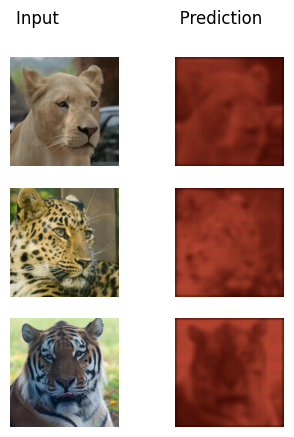

----------------------------------------------------------------------------------------------------
 Epochs = 4 
	 Training Loss : 0.110728  Validation Loss : 0.1089366, Memory Left : 12.516/39.424 GB, C.P.

   - Plotting Sample inference -


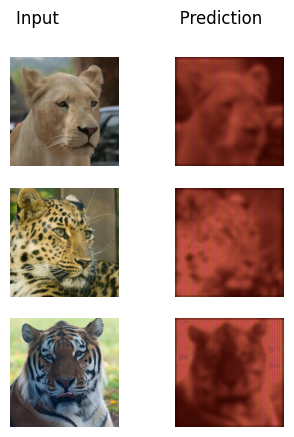

----------------------------------------------------------------------------------------------------
 Epochs = 5 
	 Training Loss : 0.0928959  Validation Loss : 0.0974425, Memory Left : 12.516/39.424 GB, C.P.

   - Plotting Sample inference -


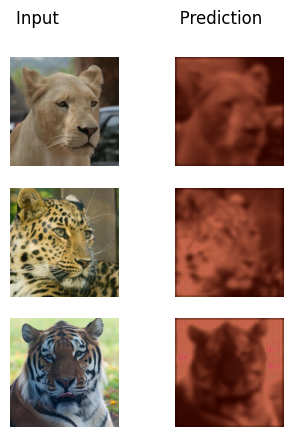

----------------------------------------------------------------------------------------------------
 Epochs = 6 
	 Training Loss : 0.0868567  Validation Loss : 0.0890056, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 7 
	 Training Loss : 0.0847191  Validation Loss : 0.0834341, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 8 
	 Training Loss : 0.0770411  Validation Loss : 0.0740622, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 9 
	 Training Loss : 0.0640355  Validation Loss : 0.0655522, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 10 
	 Training Loss : 0.0589777  Validation Loss : 0.

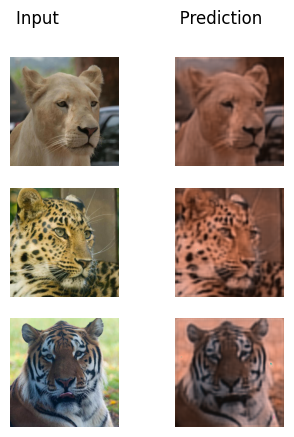

----------------------------------------------------------------------------------------------------
 Epochs = 21 
	 Training Loss : 0.0443511  Validation Loss : 0.0452974, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 22 
	 Training Loss : 0.0467616  Validation Loss : 0.0449193, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 23 
	 Training Loss : 0.0450729  Validation Loss : 0.0447025, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 24 
	 Training Loss : 0.0435205  Validation Loss : 0.0446333, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 25 
	 Training Loss : 0.0438869  Validation Loss 

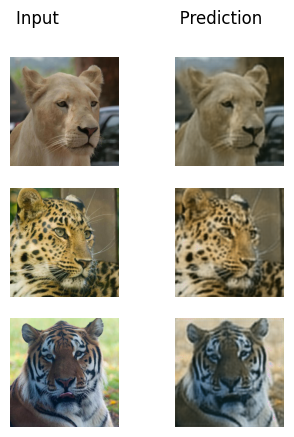

----------------------------------------------------------------------------------------------------
 Epochs = 41 
	 Training Loss : 0.0060713  Validation Loss : 0.0058952, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 42 
	 Training Loss : 0.0051994  Validation Loss : 0.0055506, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 43 
	 Training Loss : 0.0051382  Validation Loss : 0.0053754, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 44 
	 Training Loss : 0.005264  Validation Loss : 0.0052336, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 45 
	 Training Loss : 0.0050439  Validation Loss :

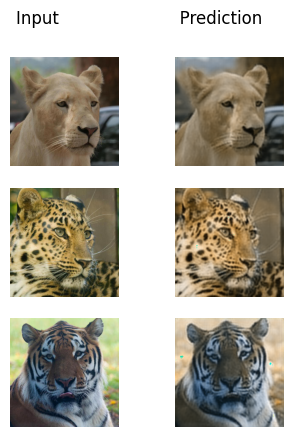

----------------------------------------------------------------------------------------------------
 Epochs = 61 
	 Training Loss : 0.004542  Validation Loss : 0.0045834, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 62 
	 Training Loss : 0.0045388  Validation Loss : 0.0045825, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 63 
	 Training Loss : 0.004404  Validation Loss : 0.0046629, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 64 
	 Training Loss : 0.0043159  Validation Loss : 0.0045149, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 65 
	 Training Loss : 0.004852  Validation Loss : 0

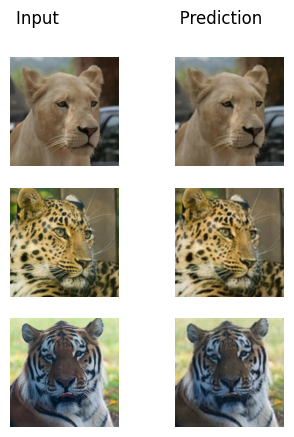

----------------------------------------------------------------------------------------------------
 Epochs = 81 
	 Training Loss : 0.0040131  Validation Loss : 0.0041748, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 82 
	 Training Loss : 0.0040808  Validation Loss : 0.0041173, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 83 
	 Training Loss : 0.0037631  Validation Loss : 0.0039395, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 84 
	 Training Loss : 0.0039931  Validation Loss : 0.0039821, Memory Left : 12.516/39.424 GB, C.P.
----------------------------------------------------------------------------------------------------
 Epochs = 85 
	 Training Loss : 0.0040898  Validation Loss 

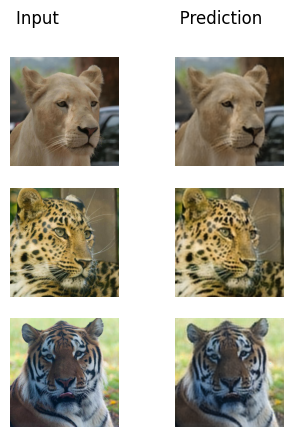

Training Done


In [10]:
if LOAD_MODEL:
    encoder = Encoder().to(device)
    decoder = Decoder().to(device)
    encoder.load_state_dict(torch.load("enc_"+MODEL_SAVE_PATH, map_location=device))
    decoder.load_state_dict(torch.load("dec_"+MODEL_SAVE_PATH, map_location=device))
    encoder.eval()
    decoder.eval()
    print("\033[1m Encoder Model Loaded Successfully \033[0m")
    print("\033[1m" + "--------- Plotting Sample inference  ---------" + "\033[0m")
    test_plot(encoder, decoder)
    
else:
    print("\033[1m" + "------------ Training started ------------" + "\033[0m")
    print(f"     \033[1m Available GPU \033[0m: {round(torch.cuda.mem_get_info()[0] / (1024 * 1024 * 1024), 3)}/{round(torch.cuda.mem_get_info()[1] / (1024 * 1024 * 1024), 3)} GB")
    optimizer=torch.optim.AdamW(list(encoder.parameters()) + list(decoder.parameters()), LEARNING_RATE)
    cnt=0
    for epoch in tqdm(range(EPOCHS)):
        try:
            print("\033[1m Epochs = {} \033[0m".format(epoch+1))
            train_loss = train_step(encoder, decoder, train_loader, loss, optimizer, device=device)
            val_loss = val_step(encoder, decoder, val_loader, loss, device=device)
            # Simple Best Model saving
            try:

                if val_loss < max_loss:
    #                 print("\t ===============    Validation Loss decreased, saving new best model    =============")
                    print(f"\t\033[1m Training Loss \033[0m: {round(train_loss,7)} \033[1m Validation Loss \033[0m: {round(val_loss,7)},\033[1m Memory Left \033[0m: {round(torch.cuda.mem_get_info()[0] / (1024 * 1024 * 1024), 3)}/{round(torch.cuda.mem_get_info()[1] / (1024 * 1024 * 1024), 3)}\033[1m GB\033[0m,\033[1m C.P.\033[0m")
                    torch.save(encoder.state_dict(), "enc_"+MODEL_SAVE_PATH)
                    torch.save(decoder.state_dict(), "dec_"+MODEL_SAVE_PATH)
                    cnt=0
                else:
                    print(f"\t\033[1m Training Loss \033[0m: {round(train_loss,7)} \033[1m Validation Loss \033[0m: {round(val_loss,7)},\033[1m Memory Left \033[0m: {round(torch.cuda.mem_get_info()[0] / (1024 * 1024 * 1024), 3)}/{round(torch.cuda.mem_get_info()[1] / (1024 * 1024 * 1024), 3)}\033[1m GB\033[0m")
                    cnt+=1
                    if cnt==EARLY_STOP:
                        print("\033[1m" + "\t ------------ Early Stop  ------------" + "\033[0m")
                        break
            except Exception as e:
                max_loss=val_loss
            if ((epoch+1) %20 == 0) or (epoch<5):
                print("\n"+"\033[1m" + "   - Plotting Sample inference -" + "\033[0m")
                test_plot(encoder, decoder)
            if epoch+1==100:
                break
            print("-"*100)
        except KeyboardInterrupt:
            print("Keyboard interrupted")
            break
    print("Training Done")

## Creating Embeddings

In [11]:
if LOAD_MODEL:
    flattened_embedding=np.load(EMBEDDING_SAVE_PATH)
    print(f"Model Loaded Successfully {flattened_embedding.shape}")
else:
    embedding_dim = (1, 128, 64, 64)
    def create_embedding(encoder, full_loader, embedding_dim, device):
        test_encod=Encoder().to(device)
        test_encod.eval()
        embedding = torch.randn(embedding_dim).to(device)
        # print(embedding.shape)

        with torch.no_grad():
            for batch_idx, (train_img, target_img) in enumerate(full_loader):
                train_img = train_img.to(device)
                enc_output = test_encod(train_img)
                # print(enc_output.shape)
                embedding = torch.cat((embedding, enc_output), 0)
                # print(embedding.shape)

        return embedding
    embedding = create_embedding(encoder, full_loader, embedding_dim, device)

    numpy_embedding = embedding.cpu().detach().numpy()
    num_images = numpy_embedding.shape[0]

    # Dump the embeddings for complete dataset, not just train
    flattened_embedding = numpy_embedding.reshape((num_images, -1))

    np.save(EMBEDDING_SAVE_PATH, flattened_embedding)

    print(embedding.shape, flattened_embedding.shape)

torch.Size([4739, 128, 64, 64]) (4739, 524288)


## Inferencing

In [12]:
def load_image_tensor(image_path, device):
    image_tensor = T.ToTensor()(Image.open(image_path))
    image_tensor = image_tensor.unsqueeze(0)
    return image_tensor

In [13]:
def compute_similar_images(image_path, num_images, embedding, device):
    image_tensor = load_image_tensor(image_path, device)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        image_embedding = encoder(image_tensor)
        image_embedding = image_embedding.cpu().detach().numpy()

    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    plot_similar_images(indices_list, image_path)
    return indices_list

In [14]:
def plot_similar_images(indices_list, image_path):
    indices = indices_list[0]
    print("\033[1m" + "\t\t Test Image" + "\033[0m")
    img=Image.open(image_path).convert("RGB").resize((IMG_HEIGHT,IMG_WIDTH))
    img.show()
    print("="*100,'\n',"\033[1m" + "\t\t Results" + "\033[0m")
    for index in indices:
        img_name = str(index - 1) + ".jpg"
        img_path = os.path.join("/".join(image_path.split("/")[:-1]) +"/"+ img_name)
        img = Image.open(img_path).convert("RGB")
        img.show()

		 Test Image


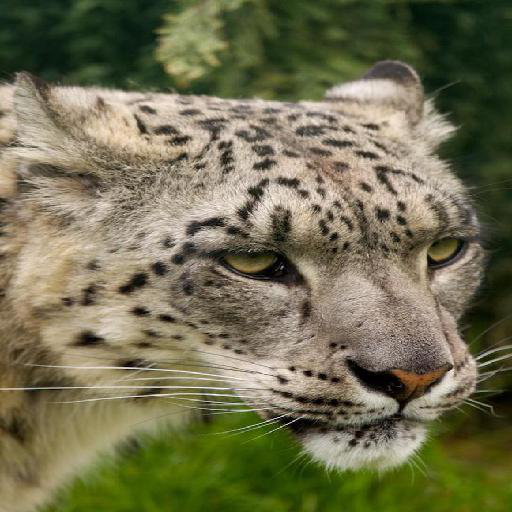

 		 Results


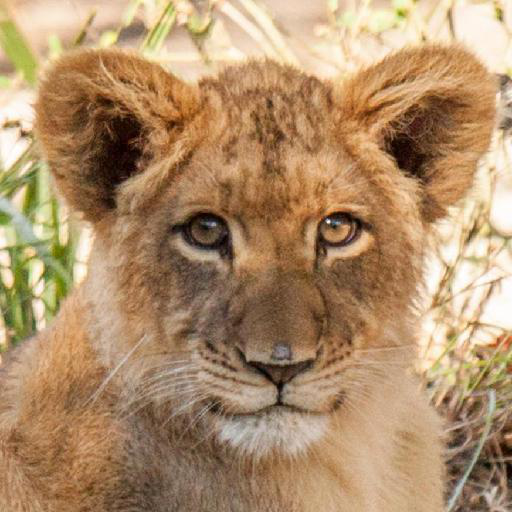

In [15]:
indices_list = compute_similar_images("data/train/1.jpg", 1, flattened_embedding, device)